# Part of Extra Work Done by Delta

Sections:

1) Data Analysis: Analyzing field values to use in defining linear filter variables and designing policy filter

2) Extra Policy Filters

3) Score Analysis: Analyzing both normalized and original score for linear regression

4) Linear filtering params: Choosing field values and simulation runs for threshold

# Required Code

In [1]:
#all imports
import pandas as pd
import numpy as np
from typing import Tuple
from sklearn.preprocessing import OneHotEncoder
#from sqlalchemy.sql.schema import ScalarElementColumnDefault

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
class DataCollector:

    def artist_styles_one_hot(self):
        raise NotImplementedError(
            "you need to implement this, needs to be two lists, one for string one for coefficient, coefficient list is one larger to account for 'other'"
            "Coefficient is from the model after training, so to prepare training data, you can put dummy number first, then replace it later after model has been trained"
        )

    def sources_one_hot(self):
        raise NotImplementedError(
            "you need to implement this, needs to be two lists, one for string one for coefficient, coefficient list is one larger to account for 'other'"
            "Coefficient is from the model after training, so to prepare training data, you can put dummy number first, then replace it later after model has been trained"
        )

    def num_inference_steps_one_hot(self):
        raise NotImplementedError(
            "you need to implement this, needs to be two lists, one for string one for coefficient, coefficient list is one larger to account for 'other'"
            "Coefficient is from the model after training, so to prepare training data, you can put dummy number first, then replace it later after model has been trained"
        )

    def one_hot_encoding_functions(self):
        return zip(
            [self.artist_styles_one_hot(), self.sources_one_hot(), self.num_inference_steps_one_hot()],
            ['artist_style', 'source', 'num_inference_steps']
        )

    def custom_aggregation(self, prefix, data):
        result = {
            f'{prefix}_likes': np.sum((data['engagement_type'] == 'Like') & (data['engagement_value'] == 1)),
            f'{prefix}_dislikes': np.sum((data['engagement_type'] == 'Like') & (data['engagement_value'] == -1)),
            f'{prefix}_engagement_time_avg': data[data['engagement_type'] == 'MillisecondsEngagedWith']['engagement_value'].mean(),
        }
        return pd.Series(result)

    def feature_generation_user(self):
        return self.user_data.groupby('user_id').apply(lambda data: self.custom_aggregation('user', data)).reset_index()

    def feature_generation_content_one_hot_encoding(self):
        for (categories, _coefficient), col_name in self.one_hot_encoding_functions():
            transformed_col = self.generated_content_metadata_data[col_name].apply(lambda x: x if x in categories else 'other').to_frame()
            encoder = OneHotEncoder(categories=[categories + ['other']], sparse=False)
            encoded_data = encoder.fit_transform(transformed_col)
            encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out([col_name]))
            for col in encoded_df.columns:
              self.generated_content_metadata_data[col] = encoded_df[col]
        return self.generated_content_metadata_data

    def feature_generation_content_engagement_value(self):
        return self.engagement_data.groupby('content_id').apply(
            lambda data: self.custom_aggregation('content', data)
        ).reset_index()

    def feature_generation(self):
      self.feature_generation_user()
      self.feature_generation_content_one_hot_encoding()
      self.feature_generation_content_engagement_value()

    def get_engagement_data(self, content_ids):
      df = pd.read_csv('sample_data/engagement.csv', sep="\t")
      return df[df['content_id'].isin(content_ids)]

    def get_generated_content_metadata_data(self, content_ids):
      df = pd.read_csv('sample_data/generated_content_metadata.csv', sep="\t")
      return df[df['content_id'].isin(content_ids)]

    def get_user_data(self, user_id):
      df = pd.read_csv('sample_data/engagement.csv', sep="\t")
      return df[df['user_id'] == user_id]

    def gather_data(self, user_id, content_ids):
      self.engagement_data = self.get_engagement_data(content_ids)
      self.generated_content_metadata_data = self.get_generated_content_metadata_data(content_ids)
      self.user_data = self.get_user_data(user_id)

    def gather_training_data(self):
      self.engagement_data = pd.read_csv('sample_data/engagement.csv', sep="\t")
      self.generated_content_metadata_data = pd.read_csv('sample_data/generated_content_metadata.csv', sep="\t")
      self.user_data = pd.read_csv('sample_data/engagement.csv', sep="\t")

    def feature_eng_training(self):
      user_attr = self.feature_generation_user()
      content_engagement_features = self.feature_generation_content_engagement_value()
      generated_content_features = self.feature_generation_content_one_hot_encoding()

      interaction_pairs = self.engagement_data[
          ['user_id', 'content_id']].drop_duplicates()

      self.training_results = pd.merge(
          interaction_pairs,
          user_attr,
          on='user_id',
          how='left'
      ).fillna(0)

      content_results = pd.merge(
          generated_content_features,
          content_engagement_features,
          on='content_id',
          how='left'
      ).fillna(0)

      self.training_results = pd.merge(
          self.training_results,
          content_results,
          on='content_id',
          how='left'
      ).fillna(0)

      return self.training_results

    def feature_eng(self):
      user_attr = self.feature_generation_user()
      content_engagement_features = self.feature_generation_content_engagement_value()
      generated_content_features = self.feature_generation_content_one_hot_encoding()
      self.results = pd.merge(
          generated_content_features,
          content_engagement_features,
          on='content_id',
          how='left'
      ).fillna(0)
      self.results['user_id'] = user_attr['user_id'].iloc[0]
      self.results = pd.merge(
          self.results,
          user_attr,
          on='user_id'
      )

    def threshold(self):
        raise NotImplementedError("you need to implement")

    def coefficients(self):
        return {
            'content_likes': 0.0,
            'content_dislikes': 0.0,
            'content_engagement_time_avg': 0.0,

            'user_likes': 0.0,
            'user_dislikes': 0.0,
            'user_engagement_time_avg': 0.0,
        }

    def get_columns(self):
      cols = list(self.coefficients().keys())
      for (categories, _coefficients), col_name in self.one_hot_encoding_functions():
          for category, coefficient in zip(categories + ['other'], _coefficients):
            cols.append(col_name + "_" + str(category))
      return cols

    def run_linear_model(self):
        coeffs = self.coefficients()
        for (categories, _coefficients), col_name in self.one_hot_encoding_functions():
          for category, coefficient in zip(categories + ['other'], _coefficients):
            coeffs[col_name + "_" + str(category)] = coefficient

        self.results['linear_output'] = 0.0
        for col_name, _coefficient in coeffs.items():
            self.results['linear_output'] += self.results[col_name] * _coefficient
        return self.results[self.results['linear_output'] >= self.threshold()]['content_id'].values

    def filter_content_ids(self, user_id, content_ids):
      self.gather_data(user_id, content_ids)
      self.feature_eng()
      return self.run_linear_model()

In [3]:
class DataCollectorDelta(DataCollector):

    def artist_styles_one_hot(self):
        artstyles_no_movie = [
            'shepard_fairey',
            'studio',
            'medieval',
            'unreal_engine',
            'edward_hopper',
            'anime',
            'kerry_james_marshall',
            'oil_on_canvas',
            'detailed_portrait',
            'gta_v',
            'scifi',
            'van_gogh',
            'salvador_dali',
            'jean-michel_basquiat',
            'face_and_lighting']
        style_coeffs = [
            0.004409142545343398,
            0.011894449166011137,
            0.014907388137700846,
            0.0008096059519425987,
            0.006714741985170694,
            0.009934734759402422,
            -0.014606625603665805,
            0.00794564982604023,
            -0.0007318421884443975,
            -0.005439435739255107,
            0.010627647921063176,
            0.008557881286745164,
            -0.0142722167119279,
            -0.013029608369880893,
            -0.012093821762478144,
            -0.01562769120372921]

        return artstyles_no_movie, style_coeffs

    def sources_one_hot(self):
        sources = ['human_prompts',
                'r/Showerthoughts']
        source_coeffs = [
                 0.015505005789178464,
                -0.010298992024823862,
                -0.005206013764405199]

        return sources, source_coeffs

    def num_inference_steps_one_hot(self):
        steps = [20, 100]
        step_coeffs = [
            -7.50395834568939e-05,
            0.0048317668567876846,
            -0.004756727273321751]
        return steps, step_coeffs

    def one_hot_encoding_functions(self):
        return zip(
            [self.artist_styles_one_hot(), self.sources_one_hot(), self.num_inference_steps_one_hot()],
             ['artist_style', 'source', 'num_inference_steps']
            )

    def threshold(self):
        return -0.15

    def coefficients(self):
        return {
            'content_likes': 0.008504499974045877,
            'content_dislikes': -0.018620360912729533,
            'content_engagement_time_avg': 1.939212871998199e-10,
            'user_likes': 4.6184837227071535e-05,
            'user_dislikes': -5.319159929086619e-05,
            'user_engagement_time_avg': 9.385624489095923e-08,
            }

In [5]:
#@title get training data
data_collector = DataCollectorDelta()
data_collector.gather_training_data()
training_data = data_collector.feature_eng_training()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# 1) Data Analysis: Analyzing field values to use in defining linear filter variables and designing policy filter

tried to find important/influential field values for linear filtering

tried to find (combinations of) field values with most and least engagement for policy filtering

1.1) Analyzing artist_style

In [7]:
training_data['artist_style'].value_counts(normalize=True, dropna=False).head(20)

0                       0.348707
medieval                0.018746
anime                   0.013861
shepard_fairey          0.011558
studio                  0.011323
oil_on_canvas           0.011274
keith_haring            0.010240
unreal_engine           0.010066
edward_hopper           0.009813
detailed_portrait       0.009701
juan_gris               0.009658
jackson_pollock         0.009311
ibrahim_el_salahi       0.008878
scifi                   0.008803
van_gogh                0.008618
ma_jir_bo               0.008401
franck_slama            0.008382
kerry_james_marshall    0.008296
marta_minujín           0.008265
face_and_lighting       0.007807
Name: artist_style, dtype: float64

In [11]:
#this was done for various important artist styles
training_data[training_data['artist_style'] == 'medieval'].describe()

,user_id,content_id,user_likes,user_dislikes,user_engagement_time_avg,guidance_scale,num_inference_steps,artist_style_shepard_fairey,artist_style_studio,artist_style_medieval,...,artist_style_other,source_human_prompts,source_r/Showerthoughts,source_other,num_inference_steps_20,num_inference_steps_100,num_inference_steps_other,content_likes,content_dislikes,content_engagement_time_avg
count,3028.000000,3028.000000,3028.000000,3028.000000,3028.000000,3028.000000,3028.000000,3028.0,3028.0,3028.0,...,3028.0,3028.0,3028.000000,3028.000000,3028.000000,3028.000000,3028.000000,3028.000000,3028.000000,3028.000000
mean,54.563078,120304.563738,630.686592,487.281374,42998.772078,7.639366,42.351387,0.0,0.0,1.0,...,0.0,0.0,0.279062,0.720938,0.512550,0.154557,0.332893,10.151915,1.542602,15001.883003
std,31.870749,6137.691487,565.893431,490.924223,90322.015414,2.318979,28.097112,0.0,0.0,0.0,...,0.0,0.0,0.448612,0.448612,0.499925,0.361542,0.471326,8.995468,1.602928,84868.593114
min,1.000000,110621.000000,3.000000,0.000000,945.736951,3.000000,20.000000,0.0,0.0,1.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,115042.000000,245.000000,175.000000,4123.203125,8.000000,20.000000,0.0,0.0,1.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,1665.250000
50%,52.000000,119163.000000,508.000000,320.000000,8745.763085,8.000000,20.000000,0.0,0.0,1.0,...,0.0,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,8.000000,1.000000,2526.700000
75%,83.000000,125842.000000,837.000000,656.000000,41205.936639,10.000000,50.000000,0.0,0.0,1.0,...,0.0,0.0,1.000000,1.000000,1.000000,0.000000,1.000000,16.000000,2.000000,3346.705128
max,113.000000,131388.000000,2891.000000,2794.000000,803651.618492,10.000000,100.000000,0.0,0.0,1.0,...,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,30.000000,11.000000,685512.000000


In [17]:
training_data[training_data['artist_style'] == '0'].describe()

,user_id,content_id,user_likes,user_dislikes,user_engagement_time_avg,guidance_scale,num_inference_steps,artist_style_shepard_fairey,artist_style_studio,artist_style_medieval,...,artist_style_other,source_human_prompts,source_r/Showerthoughts,source_other,num_inference_steps_20,num_inference_steps_100,num_inference_steps_other,content_likes,content_dislikes,content_engagement_time_avg
count,56326.000000,56326.000000,56326.000000,56326.000000,56326.000000,56326.000000,56326.000000,56326.0,56326.0,56326.0,...,56326.0,56326.000000,56326.0,56326.000000,56326.000000,56326.0,56326.000000,56326.00000,56326.000000,5.632600e+04
mean,52.938820,100080.172727,571.916557,453.011007,38902.072310,9.162838,70.979477,0.0,0.0,0.0,...,1.0,0.909527,0.0,0.090473,0.058623,0.0,0.941377,4.74834,1.012925,2.398973e+04
std,30.138794,12900.892891,518.033182,485.950598,83756.844419,3.631490,13.456585,0.0,0.0,0.0,...,0.0,0.286861,0.0,0.286861,0.234920,0.0,0.234920,6.71989,1.248940,8.938217e+05
min,1.000000,84424.000000,0.000000,0.000000,945.736951,1.000000,20.000000,0.0,0.0,0.0,...,1.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000e+00
25%,29.000000,90663.750000,188.000000,156.000000,4009.613200,7.000000,75.000000,0.0,0.0,0.0,...,1.0,1.000000,0.0,0.000000,0.000000,0.0,1.000000,0.00000,0.000000,1.420500e+03
50%,50.000000,97548.000000,484.000000,290.000000,8745.763085,7.000000,75.000000,0.0,0.0,0.0,...,1.0,1.000000,0.0,0.000000,0.000000,0.0,1.000000,2.00000,1.000000,2.045864e+03
75%,74.000000,105565.750000,789.000000,538.000000,33305.916977,10.000000,75.000000,0.0,0.0,0.0,...,1.0,1.000000,0.0,0.000000,0.000000,0.0,1.000000,6.00000,1.000000,3.196250e+03
max,114.000000,136303.000000,2891.000000,2794.000000,803651.618492,50.000000,75.000000,0.0,0.0,0.0,...,1.0,1.000000,0.0,1.000000,1.000000,0.0,1.000000,42.00000,10.000000,1.027362e+08


In [8]:
sum_engagement_by_style = training_data.groupby('artist_style').agg(
    content_engagement_time_avg_users=('content_engagement_time_avg', 'mean'),
    content_id_count=('content_id', 'count')
).reset_index()

In [31]:
sum_engagement_by_style.describe()

,content_engagement_time_avg_users,content_id_count
count,1.414000e+03,1414.000000
mean,4.522754e+04,114.234795
std,3.854158e+05,1510.278925
min,0.000000e+00,1.000000
25%,2.387309e+03,26.000000
50%,3.432925e+03,42.000000
75%,6.758290e+03,64.000000
max,9.946300e+06,56326.000000


<Axes: >

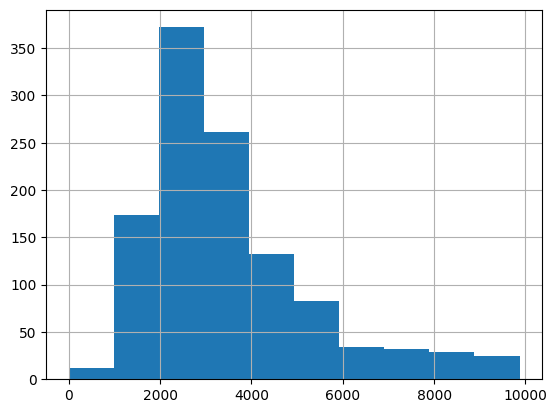

In [14]:
sum_engagement_by_style[sum_engagement_by_style['content_engagement_time_avg_users']<10000]['content_engagement_time_avg_users'].hist()

In [9]:
sum_engagement_by_style = sum_engagement_by_style.sort_values(by='content_engagement_time_avg_users', ascending=True)

In [10]:
sum_engagement_by_style.head(50)

,artist_style,content_engagement_time_avg_users,content_id_count
1293,movie: Traff,0.000000,1
253,movie: Brigsby-Bear,0.000000,1
115,movie: Apt-Pupil,533.000000,1
393,movie: Donnie-Brasco,584.720000,5
176,movie: Before-Midnight,644.666667,3
1032,movie: Rapture,704.666667,3
337,movie: Cross-of-Iron,721.500000,2
1148,movie: Smoke,750.222222,9
590,movie: Hell-or-High-Water,830.575758,11
908,movie: My-Girl,866.666667,9


In [15]:
sorted_styles = sum_engagement_by_style.sort_values(
    by=['content_engagement_time_avg_users', 'content_id_count'],
    ascending=[True, False]
)

In [16]:
sum_engagement_by_style['content_id_count'].describe()

count     1414.000000
mean       114.234795
std       1510.278925
min          1.000000
25%         26.000000
50%         42.000000
75%         64.000000
max      56326.000000
Name: content_id_count, dtype: float64

<Axes: >

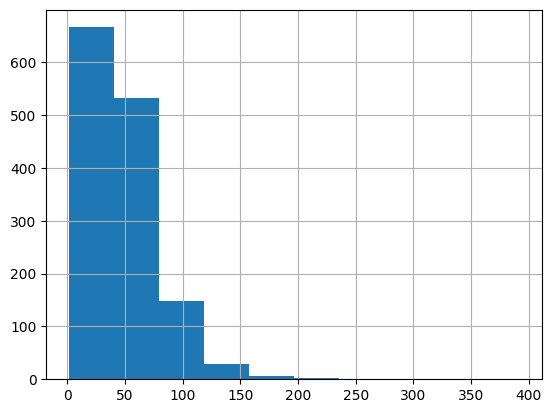

In [13]:
sum_engagement_by_style[sum_engagement_by_style['content_id_count']<1000]['content_id_count'].hist()

In [18]:
sum_engagement_by_style[sum_engagement_by_style['content_engagement_time_avg_users'] > 2500].describe()

,content_engagement_time_avg_users,content_id_count
count,1.015000e+03,1015.000000
mean,6.224839e+04,146.768473
std,4.538380e+05,1781.720181
min,2.508913e+03,1.000000
25%,3.206342e+03,32.000000
50%,4.460346e+03,49.000000
75%,1.011054e+04,70.500000
max,9.946300e+06,56326.000000


Artist Styles with < 20% quantile avg engagement time which have a good count of (content_id, user_id) and other similar analysis

In [ ]:
sum_engagement_by_style[(sum_engagement_by_style['content_engagement_time_avg_users'] < 15000) & (sum_engagement_by_style['content_id_count'] > 200)]

,artist_style,content_engagement_time_avg_users,content_id_count
163,movie: Batman,3630.196857,232
1408,scifi,3664.799377,1422
13,laura_wheeler_waring,3893.432256,1238
17,marta_minujín,4705.552893,1335
12,kerry_james_marshall,4717.790340,1340
9,jean-michel_basquiat,4832.169664,1258
657,movie: Indiana-Jones-IV,5265.066124,211
1412,unreal_engine,5582.788340,1626
1,anime,6732.629417,2239
11,keith_haring,8108.217817,1654


In [ ]:
sum_engagement_by_style[(sum_engagement_by_style['content_engagement_time_avg_users'] > 20000) & (sum_engagement_by_style['content_id_count'] > 1000)]

,artist_style,content_engagement_time_avg_users,content_id_count
528,movie: Godfather,20224.894347,231
2,detailed_portrait,23520.764917,1567
0,0,23989.730057,56326
6,gta_v,24271.476869,1142
353,movie: Dances-with-Wolves,25812.512260,306
899,movie: Mud,28860.851622,117
1043,movie: Replacements-The,31042.674573,104
16,ma_jir_bo,35987.202438,1357
923,movie: Ni-vu-ni-connu,37017.056077,141
443,movie: Fantastic-Four,38521.804156,132


In [20]:
sum_engagement_by_style[(sum_engagement_by_style['content_engagement_time_avg_users'] < 30000) & (sum_engagement_by_style['content_id_count'] > 200)]

,artist_style,content_engagement_time_avg_users,content_id_count
163,movie: Batman,3630.196857,232
1408,scifi,3664.799377,1422
13,laura_wheeler_waring,3893.432256,1238
17,marta_minujín,4705.552893,1335
12,kerry_james_marshall,4717.790340,1340
9,jean-michel_basquiat,4832.169664,1258
657,movie: Indiana-Jones-IV,5265.066124,211
1412,unreal_engine,5582.788340,1626
1,anime,6732.629417,2239
11,keith_haring,8108.217817,1654


In [21]:
sum_engagement_by_style[(sum_engagement_by_style['content_engagement_time_avg_users'] < 7400) & (sum_engagement_by_style['content_id_count'] > 200)]['artist_style'].values

array(['movie: Batman', 'scifi', 'laura_wheeler_waring', 'marta_minujín',
       'kerry_james_marshall', 'jean-michel_basquiat',
       'movie: Indiana-Jones-IV', 'unreal_engine', 'anime'], dtype=object)

We also analyzed artist styles in terms of like and dislike counts using  analysis similar to the above

1.2) Analyzing source and its combination with other fields

In [23]:
training_data['source'].value_counts(normalize=True)

human_prompts                                          0.317159
r/EarthPorn                                            0.044135
r/Showerthoughts                                       0.041411
r/scifi                                                0.016189
r/pics                                                 0.012289
                                                         ...   
Sonnet III: With how sad steps by Sir Philip Sidney    0.000006
Young Lambs by John Clare                              0.000006
On the Quotation, by George Gordon, Lord Byron         0.000006
Now I knew I lost her -- by Emily Dickinson            0.000006
The Moon upon her fluent Route by Emily Dickinson      0.000006
Name: source, Length: 3538, dtype: float64

In [15]:
avg_engagement_by_source = training_data.groupby('source').agg(
    content_engagement_time_avg_users=('content_engagement_time_avg', 'mean'),
    content_id_count=('content_id', 'count')
).reset_index()

In [16]:
avg_engagement_src_style = training_data.groupby(['source', 'artist_style']).agg(
    content_engagement_time_avg_users=('content_engagement_time_avg', 'mean'),
    content_id_count=('content_id', 'count')
).reset_index()

In [17]:
avg_engagement_src_style.describe()

,content_engagement_time_avg_users,content_id_count
count,6.557000e+03,6557.000000
mean,2.204418e+04,24.634436
std,3.366245e+05,633.441265
min,0.000000e+00,1.000000
25%,1.284465e+03,2.000000
50%,2.116210e+03,3.000000
75%,3.606750e+03,16.000000
max,1.579409e+07,51230.000000


<Axes: >

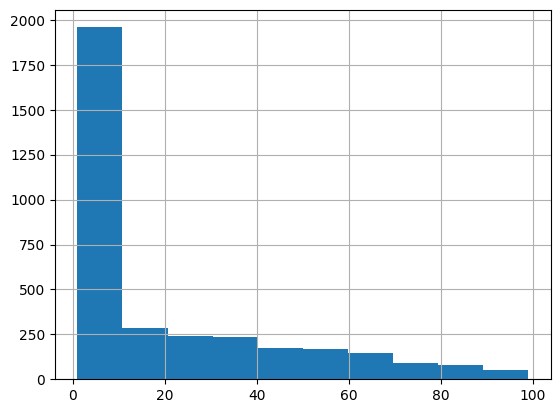

In [22]:
avg_engagement_by_source[avg_engagement_by_source['content_id_count']<100]['content_id_count'].hist()

<Axes: >

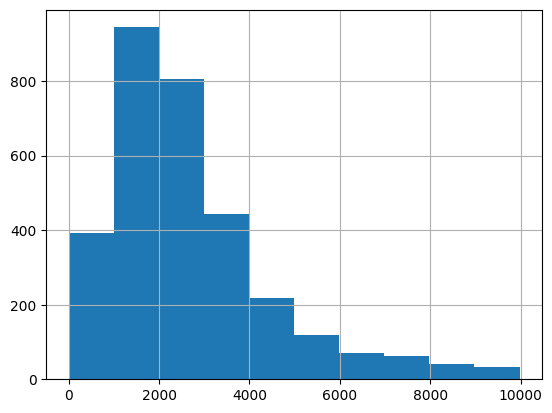

In [23]:
avg_engagement_by_source[avg_engagement_by_source['content_engagement_time_avg_users']<10000]['content_engagement_time_avg_users'].hist()

In [26]:
avg_engagement_by_source[avg_engagement_by_source['content_id_count']>200].sort_values(by='content_engagement_time_avg_users', ascending=True)

,source,content_engagement_time_avg_users,content_id_count
3468,Winston Churchill,2510.976207,304
3525,r/Cyberpunk,2896.277290,534
545,Buddha,3222.018921,365
396,Batman,3630.196857,232
3534,r/pics,4337.541475,1985
3531,r/SimplePrompts,4698.166854,1096
1475,Indiana-Jones-IV,5265.066124,211
3532,r/educationalgifs,5354.293440,1207
3535,r/scifi,5365.317798,2615
3529,r/RetroFuturism,5430.773120,648


In [ ]:
avg_engagement_src_style[avg_engagement_src_style['content_id_count']>200].sort_values(by='content_engagement_time_avg_users', ascending=True)

,source,artist_style,content_engagement_time_avg_users,content_id_count
6378,r/Showerthoughts,detailed_portrait,2548.469032,257
6495,r/pics,medieval,2619.913830,302
6319,r/EarthPorn,oil_on_canvas,2773.337350,315
6325,r/EarthPorn,unreal_engine,2784.077261,326
6324,r/EarthPorn,takashi_murakami,2963.933699,362
6307,r/EarthPorn,ibrahim_el_salahi,2973.729087,489
6388,r/Showerthoughts,kerry_james_marshall,3010.338784,328
6380,r/Showerthoughts,face_and_lighting,3085.263778,306
6313,r/EarthPorn,laura_wheeler_waring,3464.199689,207
6312,r/EarthPorn,kerry_james_marshall,3600.146641,293


1.3) Analyzing guidance scale and its combination with other fields

In [22]:
training_data['guidance_scale'].value_counts()

8     49497
7     39478
10    25114
4     16138
9     12922
3      4269
12     2732
15     2507
13     2506
11     1458
20     1298
14     1104
18      585
16      572
17      349
19      276
6       263
5       215
30       79
21       34
25       29
29       15
27       13
22       13
28       11
24       10
40        8
1         8
2         6
38        3
23        3
50        3
45        3
42        3
35        2
44        1
41        1
Name: guidance_scale, dtype: int64

In [ ]:
avg_engagement_src_style_guid = training_data.groupby(['source', 'artist_style', 'guidance_scale']).agg(
    content_engagement_time_avg_users=('content_engagement_time_avg', 'mean'),
    content_id_count=('content_id', 'count')
).reset_index()

In [ ]:
avg_engagement_src_style_guid[avg_engagement_src_style_guid['content_id_count']>200].sort_values(by='content_engagement_time_avg_users', ascending=True)

,source,artist_style,guidance_scale,content_engagement_time_avg_users,content_id_count
13303,r/EarthPorn,takashi_murakami,8,2752.770836,206
13573,r/Showerthoughts,medieval,8,2937.727471,443
12898,human_prompts,0,11,3038.722649,1458
12892,human_prompts,0,5,3606.384228,215
12905,human_prompts,0,18,4252.696562,585
12893,human_prompts,0,6,5308.003829,263
12906,human_prompts,0,19,5797.422520,276
12903,human_prompts,0,16,6693.576302,572
12895,human_prompts,0,8,7504.083023,1395
12907,human_prompts,0,20,8377.810246,1298


*guidance scale in [7, 10, 15, 17] (which constitute 36000) and source = human_prompt have high engagement
human prompt is 51000/160000  = 32%
also ['Dances-with-Wolves', 'r/Damnthatsinteresting', 'r/MadeMeSmile', 'Johann Wolfgang von Goethe', 'r/AccidentalArt', 'Laozi'] have even higher engagement (but much less frequent)*

# 2) Extra Policy Filters

In [28]:
#removes most of everything that is not human prompt with guidance scale in [7, 10, 15, 17] based on above analysis
def policy_filter_one(training_data, content_ids):

    filtered_data = training_data[training_data['content_id'].isin(content_ids)].drop_duplicates(subset=['content_id'])

    ## calculate the number of contents for each artist_style
    src_counts = filtered_data["source"].value_counts().to_dict()

    keep_sources = ['human_prompts', 'Dances-with-Wolves', 'r/Damnthatsinteresting', 'r/MadeMeSmile', 'Johann Wolfgang von Goethe', 'r/AccidentalArt', 'Laozi']

    # Calculate the total number of contents
    total_contents = len(content_ids)

    # Calculate the maximum allowable count for sources
    #max_allowed_count = int(total_contents * 0.00001)
    max_allowed_count = 0

    ids_to_remove = []
    # Iterate through artists and check their counts
    for src in src_counts:
        if src not in keep_sources:
            src_count = src_counts[src]
            if(src_count > max_allowed_count):
              remove_count = src_count - max_allowed_count
              ids_to_remove.extend(filtered_data[filtered_data['source'] == src].sample(remove_count)['content_id'])
              #print(len(indices_to_remove))

    condition_1 = filtered_data['source'] == 'human_prompts'
    condition_2 = ~filtered_data['guidance_scale'].isin([7, 10, 15, 17])
    ids_to_remove.extend(filtered_data[condition_1 & condition_2]['content_id'])

    #change the ratio based on how much linear is expected to filter
    #if we are dropping too much, we should not do so
    stop_index = len(ids_to_remove) + 1
    # if len(indices_to_remove) / len(content_ids) > 3/13:
    #   stop_index = int(len(content_ids) * 3/13)

    remove_set = set(ids_to_remove[:stop_index])
    filtered_indices = [id for id in content_ids if id not in remove_set]

    return filtered_indices

In [29]:
#at most 0.001% of content should have art style in ['movie: Batman', 'scifi', 'laura_wheeler_waring', 'marta_minujín',
#'kerry_james_marshall', 'jean-michel_basquiat', 'movie: Indiana-Jones-IV', 'unreal_engine', 'anime']

def policy_filter_two(training_data, content_ids):

    filtered_data = training_data[training_data['content_id'].isin(content_ids)].drop_duplicates(subset=['content_id'])

    ## calculate the number of contents for each artist_style
    artstyle_counts = filtered_data["artist_style"].value_counts().to_dict()

    artstyles = ['movie: Batman', 'scifi', 'laura_wheeler_waring', 'marta_minujín','kerry_james_marshall', 'jean-michel_basquiat', 'movie: Indiana-Jones-IV', 'unreal_engine', 'anime']

    # Calculate the total number of contents
    total_contents = len(content_ids)

    # Calculate the maximum allowable count for the artists
    max_allowed_count = int(total_contents * 0.00001)

    indices_to_remove = []
    # Iterate through artists and check their counts
    for style in artstyles:
        if style in artstyle_counts:
            style_count = artstyle_counts[style]
            if(style_count > max_allowed_count):
              remove_count = style_count - max_allowed_count
              indices_to_remove.extend(filtered_data[filtered_data['artist_style'] == style].sample(remove_count).index)

    #change the ratio based on how much linear is expected to filter
    #if we are dropping too much, we should not do so
    stop_index = len(indices_to_remove) + 1
    # if len(indices_to_remove) / len(content_ids) > 3/13:
    #   stop_index = int(len(content_ids) * 3/13)

    remove_set = set(indices_to_remove[:stop_index])
    filtered_indices = [index for index in content_ids if index not in remove_set]

    return filtered_indices

# 3) Score Analysis: Analyzing both normalized and original score for linear regression

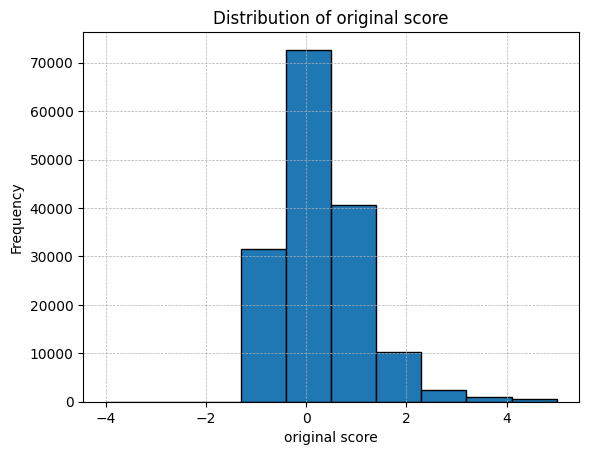

<ipython-input-8-fae1ae76a0d9>:43: RuntimeWarning: invalid value encountered in double_scalars
  lambda x: (x['original_score'] - x['min']) / (abs(x['max']-x['min'])),


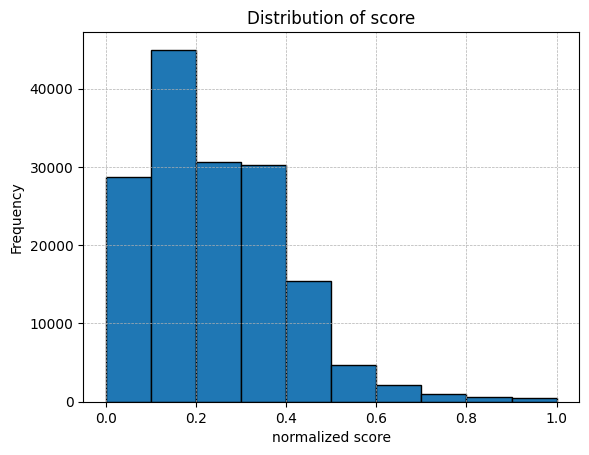

In [ ]:
#@title code to implement
def get_Y(engagement_data: pd.DataFrame) -> pd.DataFrame:
    """Engineers taget variable.
    Args
      data (pd.DataFrame): Engagement data.
    Returns
      pd.DataFrame: Dataframe of 3 columns; 'user_id', 'content_id', 'score',
        where 'score' being the target variable that you want to predict.
    """
    # Dummy target dataframe. Your output dataframe should have 3 columns; 'user_id', 'content_id', 'score'
    # Where 'score' being the target variable that you want to predict.

    engagement_data['modified_engagement_value'] = engagement_data.apply(
    lambda row: row['engagement_value'] if row['engagement_type'] == 'Like' else 0.0001 * row['engagement_value'],
    axis=1
)

    grouped_data = engagement_data.groupby(
        ['user_id', 'content_id']
    )['modified_engagement_value'].sum().reset_index(name='original_score')

    grouped_data = grouped_data[grouped_data['original_score'] <= 5] #was 10


    import matplotlib.pyplot as plt

    # Plotting the histogram of original scores
    grouped_data['original_score'].plot(kind='hist', edgecolor='black', bins=10)
    plt.title('Distribution of original score')
    plt.xlabel('original score')
    plt.ylabel('Frequency')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()



# Calculate min and max scores for each user
    score_stats = grouped_data.groupby('user_id')['original_score'].agg(['min', 'max']).reset_index()

    grouped_data = grouped_data.merge(score_stats, on='user_id', how='left')

    grouped_data['score'] = grouped_data.apply(
        lambda x: (x['original_score'] - x['min']) / (abs(x['max']-x['min'])),
        axis=1)



    #Plotting the histogram of normalized scores
    grouped_data['score'].plot(kind='hist', edgecolor='black', bins=10)
    plt.title('Distribution of score')
    plt.xlabel('normalized score')
    plt.ylabel('Frequency')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()


# Merge
    target_df = pd.merge(
        training_data[['user_id', 'content_id']],
        grouped_data,
        on=['user_id', 'content_id'],
        how='left'
    )

    return target_df['score']

engagement_data = pd.read_csv('engagement.csv', sep="\t")
X = training_data[data_collector.get_columns()]
y = get_Y(engagement_data)

Xy_df = pd.concat([X, y], axis=1)

Xy_df.columns = [*X.columns, 'y']

Xy_df = Xy_df[~Xy_df['y'].isin([np.inf, -np.inf])].dropna(subset=['y'])

Xy_df = Xy_df[np.isfinite(Xy_df['y'])]

X = Xy_df.drop('y', axis=1)
y= Xy_df['y']


# normalizing score: (score - min)/max ranking

# Linear filtering params: Choosing field values and simulation runs for threshold

In [ ]:
"""
artist styles selection
step1: excluding movies (over 1000 movies, and didn't identify a clear pattern --> consider as "other");
step2: excluding artist styles that have very small coefficients in the linear model that was fitted at first using all artiststyles;
step3: further refining the selection of artist styles based on personal experience with the system
"""

"""
num_inference_steps selection
as there are four type: 20, 50, 75, 100,
we choose to include the maximum and minimum to identify possible pattern
"""

class DataCollectorDelta(DataCollector):
    def artist_styles_one_hot(self):
        artstyles_no_movie = [
 'shepard_fairey',
 'studio',
 'medieval',
 'unreal_engine',
 'edward_hopper',
 'anime',
 'kerry_james_marshall',
 'oil_on_canvas',
 'detailed_portrait',
 'gta_v',
 'scifi',
 'van_gogh',
 'salvador_dali',
 'jean-michel_basquiat',
 'face_and_lighting']
        list1 = [0.004409142545343398,
0.011894449166011137,
0.014907388137700846,
0.0008096059519425987,
0.006714741985170694,
0.009934734759402422,
-0.014606625603665805,
0.00794564982604023,
-0.0007318421884443975,
-0.005439435739255107,
0.010627647921063176,
0.008557881286745164,
-0.0142722167119279,
-0.013029608369880893,
-0.012093821762478144,
-0.01562769120372921]

        return artstyles_no_movie, list1

    def sources_one_hot(self):
        list2 = [0.015505005789178464,
-0.010298992024823862,
 -0.005206013764405199]
        return [
        'human_prompts', 'r/Showerthoughts'
    ], list2

    def num_inference_steps_one_hot(self):
        steps = [20, 100]
        list3 = [-7.50395834568939e-05,
0.0048317668567876846,
-0.004756727273321751]
        return steps, list3

    def one_hot_encoding_functions(self):
        return zip(
        [self.artist_styles_one_hot(), self.sources_one_hot(), self.num_inference_steps_one_hot()],
        ['artist_style', 'source', 'num_inference_steps']
    )

    def threshold(self):
        return -0.15
    """threshold records: % of content ids that is estimated to remain after filtering
    #0.015: 33.3%
    #0.02: 25.6%
    #0.018: 27.6%
    #0.0125: 38.9%
    #0.025: 18.2%
    #0.027:16.2%
    #0.03: 11.6%

    # -0.005：79.3%
    # -0.01：83.1%
    # -0.02: 90.3%
    # -0.03: 93.1%
    # -0.035: 94%
    # -0.04: 94.6%
    # -0.045: 96.3%

    # -0.15： 99.9%
    # -0.12: 99.7
    """

    def coefficients(self):
        return {
            'content_likes': 0.008504499974045877,
'content_dislikes': -0.018620360912729533,
'content_engagement_time_avg': 1.939212871998199e-10,
'user_likes': 4.6184837227071535e-05,
'user_dislikes': -5.319159929086619e-05,
'user_engagement_time_avg': 9.385624489095923e-08,
        }


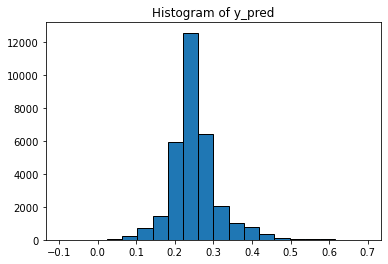

In [ ]:
"""Visualize the distribution of y_pred for threshold selection later"""
import matplotlib.pyplot as plt
plt.hist(y_pred, bins=20, edgecolor='black')
plt.title('Histogram of y_pred')
plt.show()